<h1 style="text-align: center;" markdown="1">Machine Learning Algorithms for Poverty Prediction</h1> 
<h2 style="text-align: center;" markdown="2">A project of the World Bank's Knowledge for Change Program</h2>
<h3 style="text-align: center;" markdown="3">(KCP, Grant TF0A4534)</h3>


> *This notebook is part of a series that has been developed as an empirical comparative assessment of machine learning classification algorithms applied to poverty prediction. The objectives of this project are to explore how well machine learning algorithms perform when given the task to identify the poor in a given population, and to provide a resource of machine learning techniques for researchers, data scientists, and statisticians in developing countries.*

<h1 style="text-align: center;" markdown="3">Algorithm 3 - K-Nearest Neighbors Classifier</h1> 
<h2 style="text-align: center;" markdown="3">Part 2: Indonesia Poverty Prediction</h2> 

# Table of Contents
[Introduction](#introduction)  
[KNN with Simple Features](#knn-simple)  
[KNN with Full Features](#knn-full)  
&nbsp;&nbsp;&nbsp;[Undersampling](#undersampling)  
&nbsp;&nbsp;&nbsp;[Oversampling](#oversampling)  
&nbsp;&nbsp;&nbsp;[Tune Parameters and Cross-Validate](#tune-cv)  
[Summary](#summary)

# Introduction <a class="anchor" id="introduction"></a>

We will now apply the KNN classifier to the Indonesia dataset and explore how having an unbalanced dataset impacts the classifier performance. 

As always, we start with loading our standard libraries and the Indonesia data

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights, 
                            load_data)
from features.process_features import get_vif, standardize
from features.process_features import IDN_BASIC_FEATURES

ALGORITHM_NAME = 'knn'
COUNTRY = 'idn'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(TRAIN_PATH)

# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 53,132 rows and 453 columns
Percent poor: 9.0% 	Percent non-poor: 91.0%


,geo_district,geo_subdistrict,geo_village,der_hhsize,hld_nbcell,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpast3mo,...,cons_333__Yes,cons_334__Yes,cons_335__Yes,cons_336__Yes,cons_338__Yes,cons_339__Yes,cons_340__Yes,cons_341__Yes,cons_342__Yes,cons_343__Yes
hid,,,,,,,,,,,,,,,,,,,,,
8271030150650101,8271,30,15,5,1,1,2,2,5,1,...,1,0,0,0,0,0,0,0,0,0
7316020200500509,7316,20,13,5,1,4,0,1,2,0,...,1,0,0,0,0,0,0,0,0,0
5108050200860107,5108,50,4,3,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,1,0
3301190201430210,3301,190,15,2,1,0,1,1,2,2,...,0,0,0,0,0,0,0,0,0,0
6304140250030508,6304,140,4,6,4,1,3,2,5,3,...,0,0,0,0,0,0,0,0,0,0


# KNN with simple features <a class="anchor" id="knn-simple"></a>

We'll start with the simple set of features stored in `IDN_BASIC_FEATURES` in the `process_features` module.


KNN can take a long time to run, especially on large datasets. Beause of this, we'll add a `SUBSAMPLE` variable to downsample the size of the dataset by default. To run these algorithms across all of the data, set `SUBSAMPLE = 1`. Results will not match the published results when the notebook only uses a portion of the training data.

In [3]:
SUBSAMPLE = 0.1

def subsample(X, y, w, stratify=True, seed=566):
    n_samples = int(SUBSAMPLE * X.shape[0])
    
    rng = np.random.RandomState(seed)
    
    if stratify:
        y_rate = y.mean()
        n_true = int(n_samples * y_rate)
        n_false = n_samples - n_true
        
        true_idx = rng.choice(np.where(y)[0], n_true, replace=False)
        false_idx = rng.choice(np.where(~y)[0], n_false, replace=False)
        
        sample_idx = np.union1d(true_idx, false_idx)
    else:
        sample_idx = rng.choice(np.arange(X.shape[0]), n_samples, replace=False)
    
    return X.iloc[sample_idx, :], y[sample_idx], w[sample_idx]

In [4]:
# Select the basic features we've used previously
selected_columns = IDN_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (53132, 9)


CPU times: user 33.1 ms, sys: 204 µs, total: 33.3 ms
Wall time: 57.3 ms
CPU times: user 274 ms, sys: 292 µs, total: 274 ms
Wall time: 787 ms
In-sample score: 91.13%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


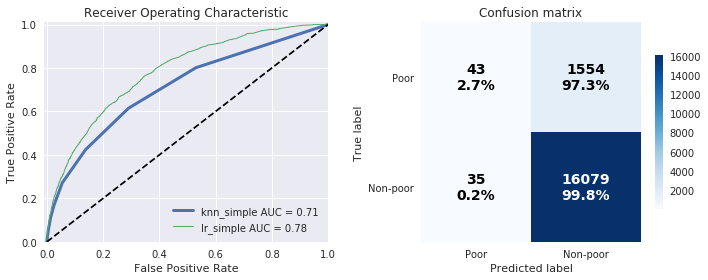

,knn_simple,lr_simple
accuracy,0.910282,0.91158
recall,0.0269255,0.0851597
precision,0.551282,0.564315
f1,0.0513433,0.147987
cross_entropy,0.818091,0.256817
roc_auc,0.710226,0.781848
cohen_kappa,0.0433091,0.127352


Actual poverty rate: 11.38% 
Predicted poverty rate: 0.26% 


In [5]:
from sklearn.neighbors import KNeighborsClassifier

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH, 
                                      selected_columns=selected_columns)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = KNeighborsClassifier(n_neighbors=15)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH, 
                                   selected_columns=selected_columns)

# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

As usual, the basic KNN classifier has a very poor recall rate on the unbalanced dataset, so once again we will need to apply a sampling method to balance the classes.

# KNN with all features <a class="anchor" id="all-feats"></a>

Now let's apply the KNN classifier to the dataset with all features. Since this is a significantly larger dataset than Malawi, we'll keep the `n_neighbors` value lower for now and tune it later. 

**NOTE:** Running the cell below may take up to 1 hour, since KNN's computational cost is high with large datasets and hundreds of features.

CPU times: user 299 ms, sys: 0 ns, total: 299 ms
Wall time: 429 ms
CPU times: user 42 s, sys: 65.8 ms, total: 42.1 s
Wall time: 1min 29s
In-sample score: 91.77%


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


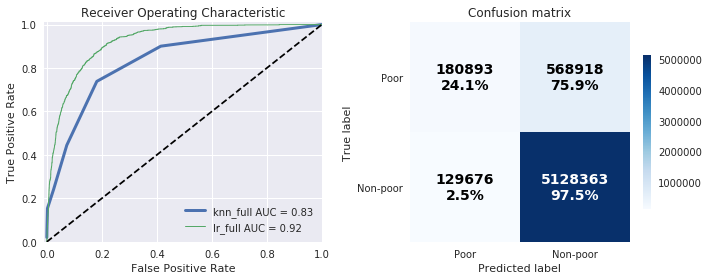

,knn_full,lr_full
accuracy,0.88372,0.910251
recall,0.241251,0.456232
precision,0.582456,0.661838
f1,0.341185,0.540131
cross_entropy,0.652805,0.212947
roc_auc,0.83278,0.923198
cohen_kappa,0.335088,0.483497


Actual poverty rate: 11.38% 
Predicted poverty rate: 4.74% 


In [6]:
# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)


# Fit the model
model = KNeighborsClassifier(n_neighbors=7)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train, w_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)
X_test, y_test, w_test = subsample(X_test, y_test, w_test)


# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models='lr_full',
                                    store_model=True,
                                    model_name='full', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

The model has a relatively low recall rate, primarily due to the unbalanced classes. 

Though the training time for this model was very small, the computational cost to get the scores and predictions was very high, taking a significant amount of time. 



## Undersampling <a class="anchor" id="undersampling">
Since the execution time to score the model using the entire training set was very high, KNN may be a good example of where we benefit from using undersampling, at least in terms of computational cost. 

X shape after undersampling:  (958, 453)
CPU times: user 17.1 ms, sys: 3.92 ms, total: 21 ms
Wall time: 45.1 ms
CPU times: user 988 ms, sys: 139 µs, total: 988 ms
Wall time: 1.09 s
In-sample score: 81.52%
CPU times: user 1.94 s, sys: 11.3 ms, total: 1.95 s
Wall time: 3.32 s
CPU times: user 1.81 s, sys: 4.02 ms, total: 1.81 s
Wall time: 2.65 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


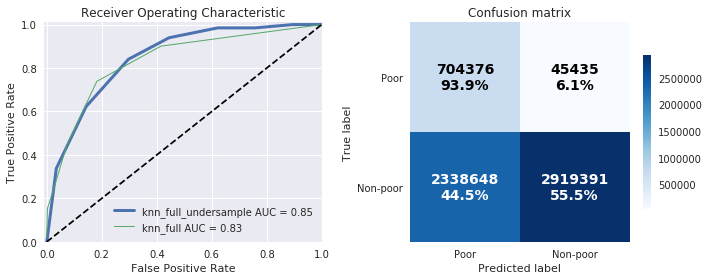

,knn_full_undersample,knn_full
accuracy,0.603172,0.88372
recall,0.939405,0.241251
precision,0.231472,0.582456
f1,0.371424,0.341185
cross_entropy,1.68043,0.652805
roc_auc,0.847533,0.83278
cohen_kappa,0.172796,0.335088


Actual poverty rate: 11.38% 
Predicted poverty rate: 48.68% 


In [7]:
from imblearn.under_sampling import RandomUnderSampler

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after undersampling: ", X_train.shape)

# Fit the model
model = KNeighborsClassifier(n_neighbors=7)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)
X_test, y_test, w_test = subsample(X_test, y_test, w_test)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['knn_full'],
                                    store_model=True,
                                    model_name='full_undersample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

## Oversampling <a class="anchor" id="oversampling">

X shape after oversampling:  (9668, 453)
CPU times: user 519 ms, sys: 3.96 ms, total: 523 ms
Wall time: 635 ms
CPU times: user 1min 49s, sys: 101 ms, total: 1min 49s
Wall time: 2min 21s
In-sample score: 65.98%
CPU times: user 24.9 s, sys: 19 ms, total: 24.9 s
Wall time: 33.2 s
CPU times: user 25 s, sys: 13.5 ms, total: 25.1 s
Wall time: 33.6 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


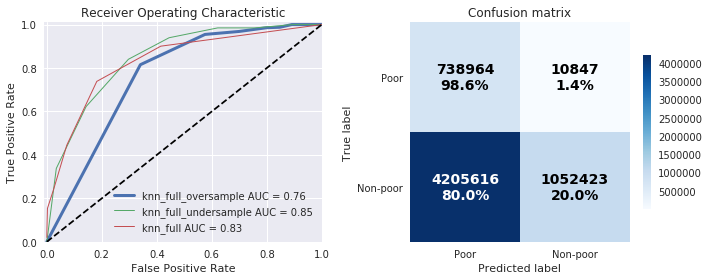

,knn_full_oversample,knn_full_undersample,knn_full
accuracy,0.298174,0.603172,0.88372
recall,0.985533,0.939405,0.241251
precision,0.149449,0.231472,0.582456
f1,0.259541,0.371424,0.341185
cross_entropy,10.9452,1.68043,0.652805
roc_auc,0.763374,0.847533,0.83278
cohen_kappa,0.0558136,0.172796,0.335088


Actual poverty rate: 11.38% 
Predicted poverty rate: 78.40% 


In [8]:
from imblearn.over_sampling import SMOTE

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply oversampling with SMOTE
X_train, y_train = SMOTE().fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train, columns=cols)
print("X shape after oversampling: ", X_train.shape)

# Fit the model
model = KNeighborsClassifier(n_neighbors=7)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)
X_test, y_test, w_test = subsample(X_test, y_test, w_test)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['knn_full_undersample', 
                                                    'knn_full'],
                                    store_model=True,
                                    model_name='full_oversample', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

## Tune parameters and cross-validate <a class="anchor" id="tune-cv"></a>

Now we try to find the best value for `n_neighbors` as we did with the Malawi dataset. Since conducting a grid search and cross-validation is already computationally expensive, we expect it to be even more so with KNN. For this reason, we will use the undersampling method to balance the training set. 

X shape after undersampling:  (958, 453)
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done   8 out of  35 | elapsed:    1.3s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.9s finished


CPU times: user 488 ms, sys: 209 ms, total: 697 ms
Wall time: 2.31 s
CPU times: user 577 ms, sys: 52 µs, total: 577 ms
Wall time: 575 ms
In-sample score: 83.61%
Best model parameters: {'n_neighbors': 5}
CPU times: user 1.08 s, sys: 99 µs, total: 1.08 s
Wall time: 1.08 s
CPU times: user 1.08 s, sys: 96 µs, total: 1.08 s
Wall time: 1.08 s


/home/bull/miniconda3/envs/worldbank-poverty-test/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


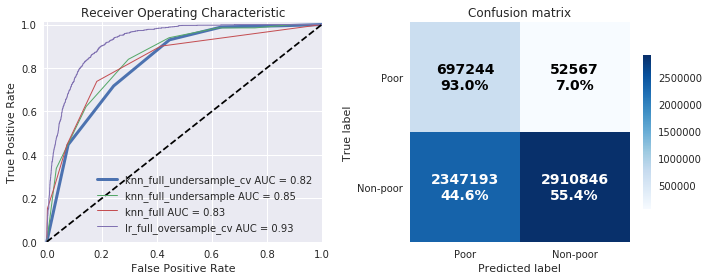

,knn_full_undersample_cv,knn_full_undersample,knn_full,lr_full_oversample_cv
accuracy,0.600563,0.603172,0.88372,0.851611
recall,0.929893,0.939405,0.241251,0.838116
precision,0.229022,0.231472,0.582456,0.427456
f1,0.367527,0.371424,0.341185,0.566159
cross_entropy,2.91987,1.68043,0.652805,0.348544
roc_auc,0.824953,0.847533,0.83278,0.925356
cohen_kappa,0.17412,0.172796,0.335088,0.471316


Actual poverty rate: 11.38% 
Predicted poverty rate: 48.32% 


In [9]:
from sklearn.model_selection import GridSearchCV

# Load and transform the training data
X_train, y_train, w_train = load_data(TRAIN_PATH)
X_train, y_train, w_train = subsample(X_train, y_train, w_train)

cols = X_train.columns

# Apply random undersampling
X_train, y_train = RandomUnderSampler().fit_sample(X_train, y_train)
print("X shape after undersampling: ", X_train.shape)

# build the model
estimator = KNeighborsClassifier()
parameters = {'n_neighbors': [3,5,7,9,11,13,15]}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5, n_jobs=-1)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
print("Best model parameters:", model.best_params_)

# Load the test set
X_test, y_test, w_test = load_data(TEST_PATH)
X_test, y_test, w_test = subsample(X_test, y_test, w_test)

# Run the model
%time y_pred = model.predict(X_test)
%time y_prob = model.predict_proba(X_test)[:,1]

# Evaluate performance and store model
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, w_test,
                                    compare_models=['knn_full_undersample',
                                                    'knn_full',
                                                    'lr_full_oversample_cv'],
                                    store_model=True,
                                    model_name='full_undersample_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=X_test.columns.values)

Cross validation for this model has only a minor impact on performance. As with Logistic Regression, we tend to get better recall using undersamping, but better overall performance using oversampling. 

# KNN Indonesia Summary <a class="anchor" id="summary"></a>



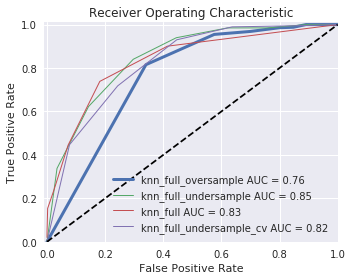

,accuracy,recall,precision,f1,cross_entropy,roc_auc,cohen_kappa,pov_rate_error
knn_full_oversample,0.298174,0.985533,0.149449,0.259541,10.9452,0.763374,0.0558136,0.67019
knn_full_undersample,0.603172,0.939405,0.231472,0.371424,1.68043,0.847533,0.172796,0.373039
knn_full,0.88372,0.241251,0.582456,0.341185,0.652805,0.83278,0.335088,-0.0663842
knn_full_undersample_cv,0.600563,0.929893,0.229022,0.367527,2.91987,0.824953,0.17412,0.369389


In [10]:
evaluation.compare_algorithm_models(ALGORITHM_NAME, COUNTRY)